In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import string
from nltk import FreqDist

In [2]:
pd.set_option("display.max_rows", 100)

# Read in data and save to dataset

In [3]:
# To obtain CIK mapper. Do not re run in case of any changes made to the wikipedia pages
# yahoo_url = "https://finance.yahoo.com/quote/%5EDJI/components/"
# djia_table = pd.read_html(yahoo_url, header=0, index_col=0)[0]
# djia_table = djia_table.reset_index()

# wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# cik_df = pd.read_html(wiki_url,header=0,index_col=0)[0]
# cik_df['GICS Sector'] = cik_df['GICS Sector'].astype("category")
# cik_df['GICS Sub Industry'] = cik_df['GICS Sector'].astype("category")
# cik_df = cik_df.reset_index()

# cik_df = cik_df[cik_df["Symbol"].isin(djia_table.Symbol)].reset_index().drop(["index"], axis=1)
# cik_df.to_csv("cik_mapper.csv", index=False)
# cik_df.head()

In [4]:
cik_mapper = pd.read_csv("cik_mapper.csv")
cik_mapper.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrials,"St. Paul, Minnesota",NaN,66740,1902.0
1,AXP,American Express Co,reports,Financials,Financials,"New York, New York",30/6/1976,4962,1850.0
2,AAPL,Apple Inc.,reports,Information Technology,Information Technology,"Cupertino, California",30/11/1982,320193,1977.0
3,BA,Boeing Company,reports,Industrials,Industrials,"Chicago, Illinois",NaN,12927,1916.0
4,CAT,Caterpillar Inc.,reports,Industrials,Industrials,"Deerfield, Illinois",NaN,18230,1925.0


In [5]:
dataset = []
for file in glob.glob("../../Processed Data/10K10Q/Data_*/*.txt"):
    filing = file.split("\\")[-2].split("_")[1]
    additional_info = file.split("\\")[-1]
    item, cik, date = additional_info.split("_")
    dataset.append([int(cik), filing, item, pd.to_datetime(date[:-4], dayfirst=False), date.split("-")[0], file])

In [6]:
df = pd.DataFrame(dataset, columns=["CIK", "text_type", "item", "date", "year", "file_path"])
df = df.merge(cik_mapper, on="CIK")
df.head()

,CIK,text_type,item,date,year,file_path,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,Founded
0,1001039,10K,item1a,2010-11-24,2010,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN
1,1001039,10K,item1a,2011-11-23,2011,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN
2,1001039,10K,item1a,2012-11-21,2012,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN
3,1001039,10K,item1a,2013-11-20,2013,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN
4,1001039,10K,item1a,2014-11-19,2014,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN


In [7]:
df.groupby(["text_type", "item"]).count()

CIK  date  year  file_path  Symbol  Security  SEC filings  \
text_type item                                                                
10K       item1a  292   292   292        292     292       292          292   
          item7   292   292   292        292     292       292          292   
          item7a  292   292   292        292     292       292          292   
10Q       item1   862   862   862        862     862       862          862   
          item1a  740   740   740        740     740       740          740   
          item3   802   802   802        802     802       802          802   

                  GICS Sector  GICS Sub Industry  Headquarters Location  \
text_type item                                                            
10K       item1a          292                292                    292   
          item7           292                292                    292   
          item7a          292                292                    292   
10Q       item1           862                862                    862   
          item1a          740                740                    740   
          item3           802                802                    802   

                  Date first added  Founded  
text_type item                               
10K       item1a               179      159  
          item7                179      159  
          item7a               179      159  
10Q       item1                531      472  
          item1a               467      380  
          item3                531      412

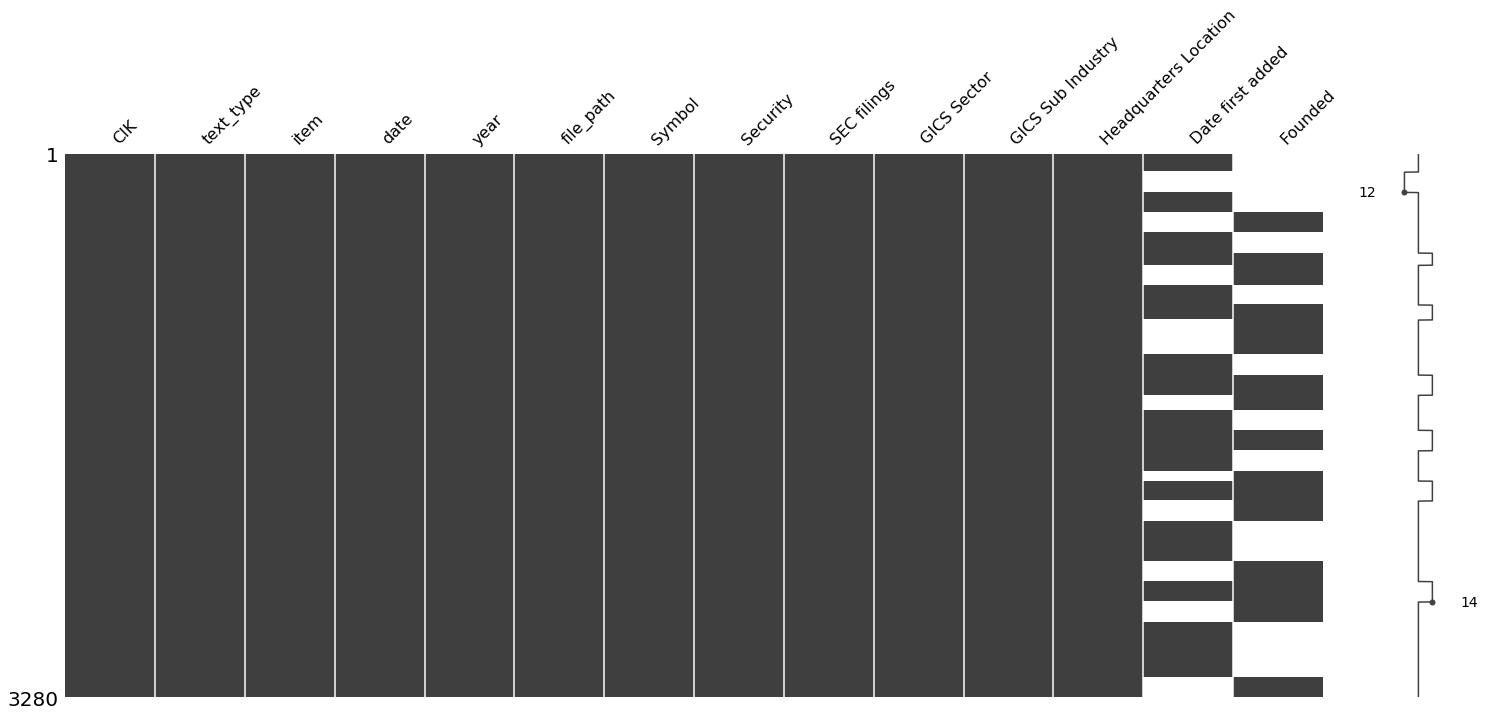

In [8]:
msno.matrix(df)

In [9]:
def first_preprocess(path):
    text = open(path, "r").read()
    text = "".join([i.lower() if not i.isdigit() and i not in string.punctuation else " " for i in text])
    text = word_tokenize(text)
    return " ".join(text)

In [10]:
tqdm().pandas()

df["raw_text"] = df.file_path.progress_apply(lambda x: first_preprocess(x))

0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 3280/3280 [02:39<00:00, 20.55it/s]


In [11]:
lm_stop_words = set(word.lower() for word in open("StopWords_Generic.txt", "r").read().split("\n"))
nltk_stop_words = set(word.translate(str.maketrans('','',string.punctuation)) for word in stopwords.words('english'))
stop_words = lm_stop_words.union(nltk_stop_words)
stop_words.union(" ")
stemmer = SnowballStemmer("english")
def preprocess(text):
    text = word_tokenize(text)
    text = [stemmer.stem(word) for word in text if word not in stop_words and len(stemmer.stem(word)) > 1]
    return " ".join(text)

In [12]:
df["processed_text"] = df.raw_text.progress_apply(lambda x: preprocess(x))

100%|██████████████████████████████████████████████████████████████████████████████| 3280/3280 [10:08<00:00,  5.39it/s]


# Some EDA

In [13]:
df.head()

,CIK,text_type,item,date,year,file_path,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,Founded,raw_text,processed_text
0,1001039,10K,item1a,2010-11-24,2010,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN,item a risk factors for an enterprise as large...,item risk factor enterpris larg complex compan...
1,1001039,10K,item1a,2011-11-23,2011,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN,item a risk factors for an enterprise as large...,item risk factor enterpris larg complex compan...
2,1001039,10K,item1a,2012-11-21,2012,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN,item a risk factors for an enterprise as large...,item risk factor enterpris larg complex compan...
3,1001039,10K,item1a,2013-11-20,2013,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN,item a risk factors for an enterprise as large...,item risk factor enterpris larg complex compan...
4,1001039,10K,item1a,2014-11-19,2014,../../Processed Data/10K10Q\Data_10K\item1a_10...,DIS,The Walt Disney Company,reports,Communication Services,Communication Services,"Burbank, California",30/6/1976,NaN,item a risk factors for an enterprise as large...,item risk factor enterpris larg complex compan...


In [14]:
dist = FreqDist(" ".join(df.raw_text.values).split())

In [15]:
for i in stop_words:
    dist.pop(i, None)

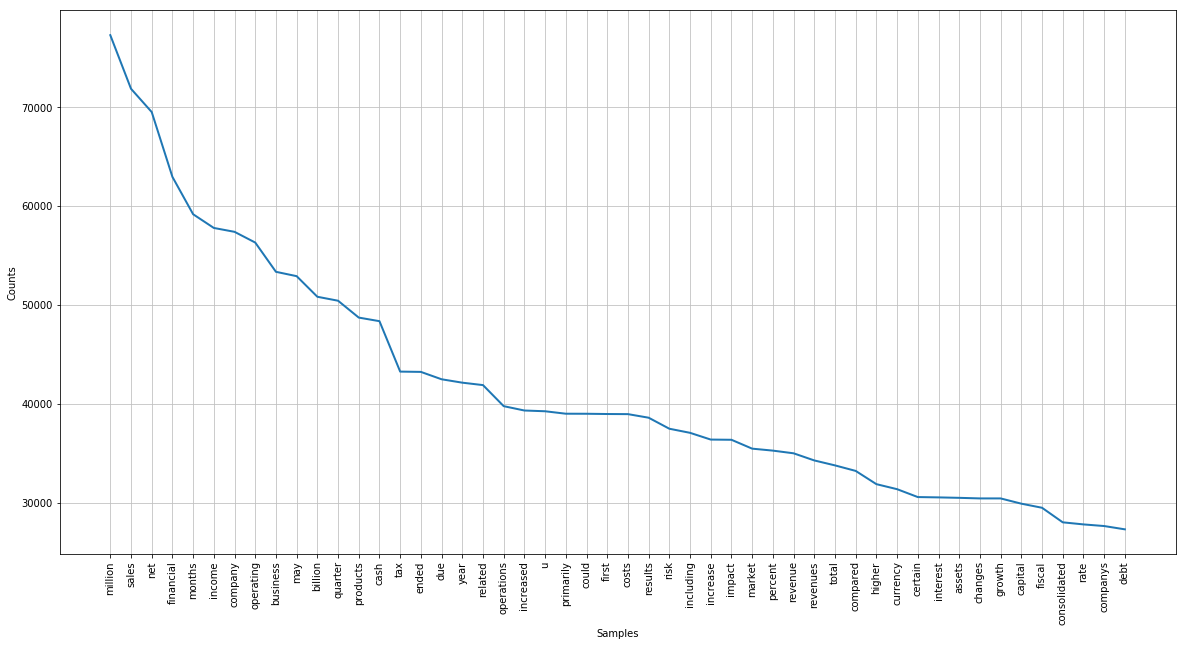

In [16]:
plt.figure(figsize = (20,10))
dist.plot(50,cumulative=False)

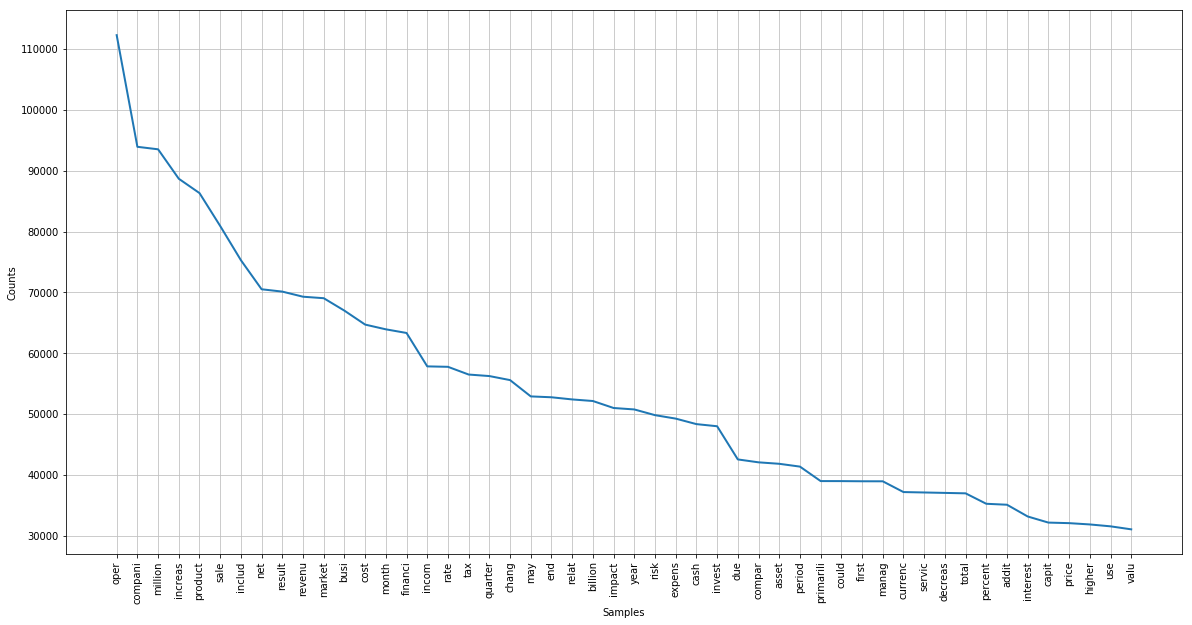

In [17]:
dist = FreqDist(" ".join(df.processed_text.values).split())
plt.figure(figsize = (20,10))
dist.plot(50,cumulative=False)

# Feature Engineering

In [18]:
macdonald = pd.ExcelFile("LoughranMcDonald_SentimentWordLists_2018.xlsx")
# macdonald.head()
macdonald.sheet_names  # see all sheet names

['Negative',
 'Positive',
 'Uncertainty',
 'Litigious',
 'StrongModal',
 'WeakModal',
 'Constraining']

In [19]:
macdonald_dict = {}
stemmer = SnowballStemmer("english")
for name in macdonald.sheet_names:
    macdonald_dict[name] = set(stemmer.stem(word) for word in macdonald.parse(name, header=None)[0].values)
    
df["num_words"] = df.processed_text.apply(lambda x: len(x.split()))

def get_sentiment_score(text, word_set):
    score = 0
    for word in text.split():
        if word in word_set:
            score += 1
    return score

for name in macdonald_dict:
    df[name] = df.processed_text.apply(lambda x: get_sentiment_score(x, macdonald_dict[name]))

In [20]:
df["date"] = pd.to_datetime(df["date"], dayfirst = False)
df["quarter"] = df.date.dt.quarter
df.sort_values(["CIK", "item", "quarter", "year"], inplace=True, kind="mergesort")
df.reset_index(inplace=True)
df.drop(columns="index", inplace=True)

In [21]:
from tqdm import tqdm_notebook
def get_raw_chng(df):
    
    df = df.sort_values(["CIK", "item", "quarter", "year"], kind="mergesort")
    features = {"Word_Raw_Chng":[np.nan]}
    feature_col_names = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']
    for i in ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']:
        features[i + "_Raw_Chng"] = [np.nan]
        
    first_row = df.loc[0]
    
    for i in tqdm_notebook(range(1, len(df))):
        second_row = df.loc[i]
        if first_row["CIK"] == second_row["CIK"] and int(first_row["year"]) < int(second_row["year"]) and first_row["quarter"] == second_row["quarter"] and first_row["item"] == second_row["item"]:
            for col in feature_col_names:
                features[col + "_Raw_Chng"].append(second_row[col] - first_row[col])
            features["Word_Raw_Chng"].append(second_row["num_words"] - first_row["num_words"])
        else:
            for col in feature_col_names:
                features[col + "_Raw_Chng"].append(np.nan)
            features["Word_Raw_Chng"].append(np.nan)
        first_row = second_row
    return features

In [22]:
features = get_raw_chng(df)
for feature in features:
    df[feature] = features[feature]

Text(0.5, 1.0, 'Negative Word Count Change Against Word Count Change')

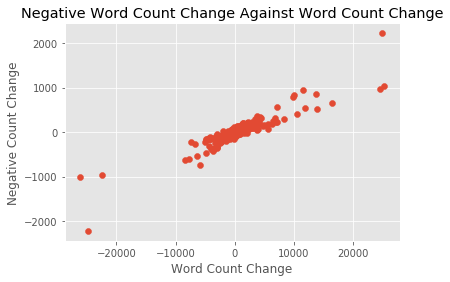

In [23]:
plt.style.use('ggplot')
%matplotlib inline
plt.scatter(df.Word_Raw_Chng, df.Negative_Raw_Chng)
plt.xlabel("Word Count Change")
plt.ylabel("Negative Count Change")
plt.title("Negative Word Count Change Against Word Count Change")

In [24]:
for name in macdonald_dict:
    df[name] = df.processed_text.apply(lambda x: get_sentiment_score(x, macdonald_dict[name])) / df.num_words

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_similarity(text1, text2, vectorizer, similarity):
    vector_1 = vectorizer.transform([text1]).toarray()
    vector_2 = vectorizer.transform([text2]).toarray()
    cosine_score = similarity(vector_1, vector_2)
    return cosine_score[0,0]

def get_all_features(df, vectorizer, name):
    
    df = df.sort_values(["CIK", "item", "quarter", "year"], kind="mergesort")
    features = {name:[np.nan], "Word_Chng":[np.nan], "Word_Raw_Chng":[np.nan]}
    feature_col_names = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']
    for i in feature_col_names:
        features[i + "_Chng"] = [np.nan]
    
    print("Fitting Corpus")
    vectorizer.fit(df[df.date < pd.to_datetime("2018-01-01", dayfirst=False)]["processed_text"].values)
    print("Finished")
    first_row = df.loc[0]
    
    for i in tqdm_notebook(range(1, len(df))):
        second_row = df.loc[i]
        if first_row["CIK"] == second_row["CIK"] and int(first_row["year"]) < int(second_row["year"]) and first_row["quarter"] == second_row["quarter"] and first_row["item"] == second_row["item"]:
            features[name].append(compute_similarity(first_row["processed_text"], second_row["processed_text"], vectorizer, cosine_similarity))
            for col in feature_col_names:
                features[col + "_Chng"].append(second_row[col] - first_row[col])
            features["Word_Chng"].append((second_row["num_words"] - first_row["num_words"])/(first_row["num_words"]+1))
            features["Word_Raw_Chng"].append(second_row["num_words"] - first_row["num_words"])
        else:
            for col in feature_col_names:
                features[col + "_Chng"].append(np.nan)
            features[name].append(np.nan)
            features["Word_Raw_Chng"].append(np.nan)
            features["Word_Chng"].append(np.nan)
        first_row = second_row
    return features

In [26]:
features = get_all_features(df, CountVectorizer(min_df = 5, ngram_range=(1,2)), "bow_sim")
for feature in features:
    df[feature] = features[feature]

Fitting Corpus
Finished


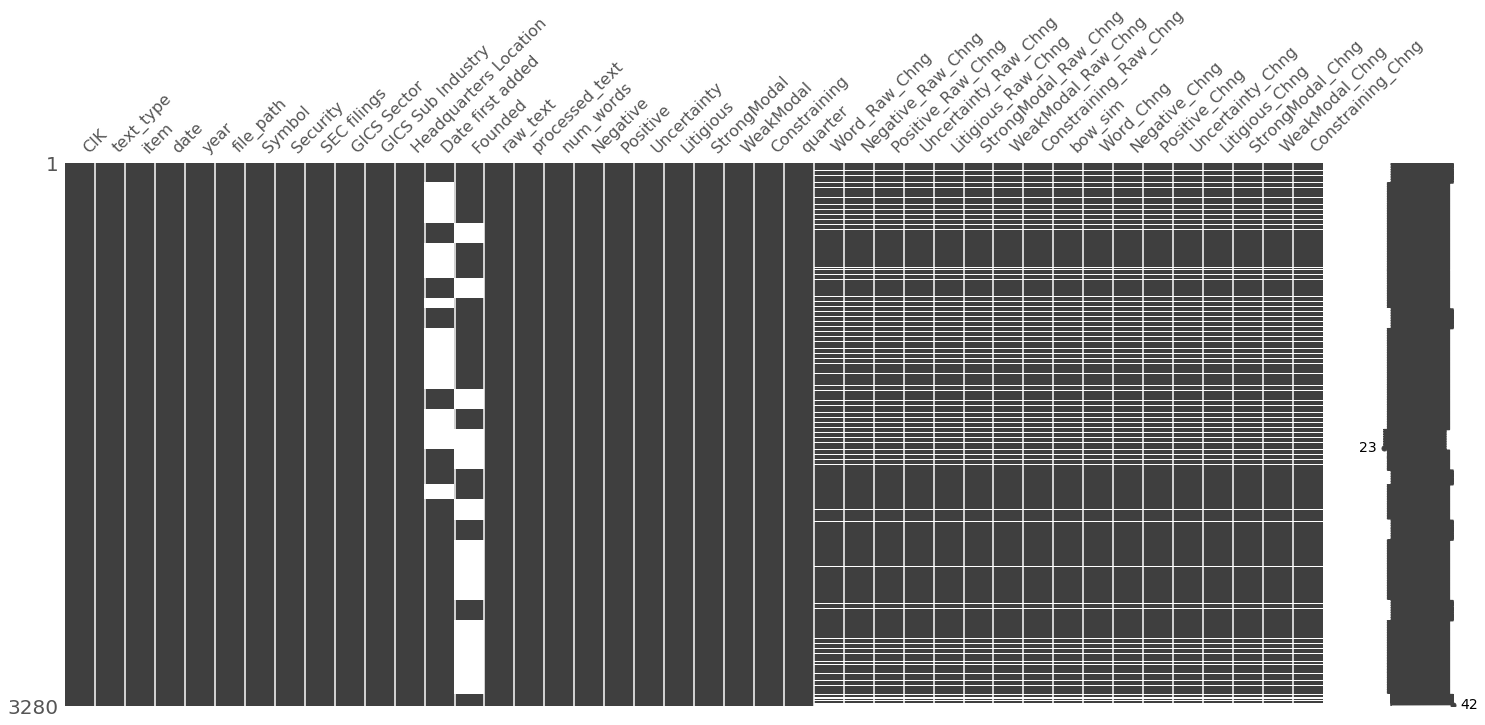

In [27]:
msno.matrix(df)

In [28]:
features = get_all_features(df, TfidfVectorizer(min_df = 5, ngram_range=(1,2)), "tfidf_sim")
for feature in features:
    df[feature] = features[feature]

Fitting Corpus
Finished


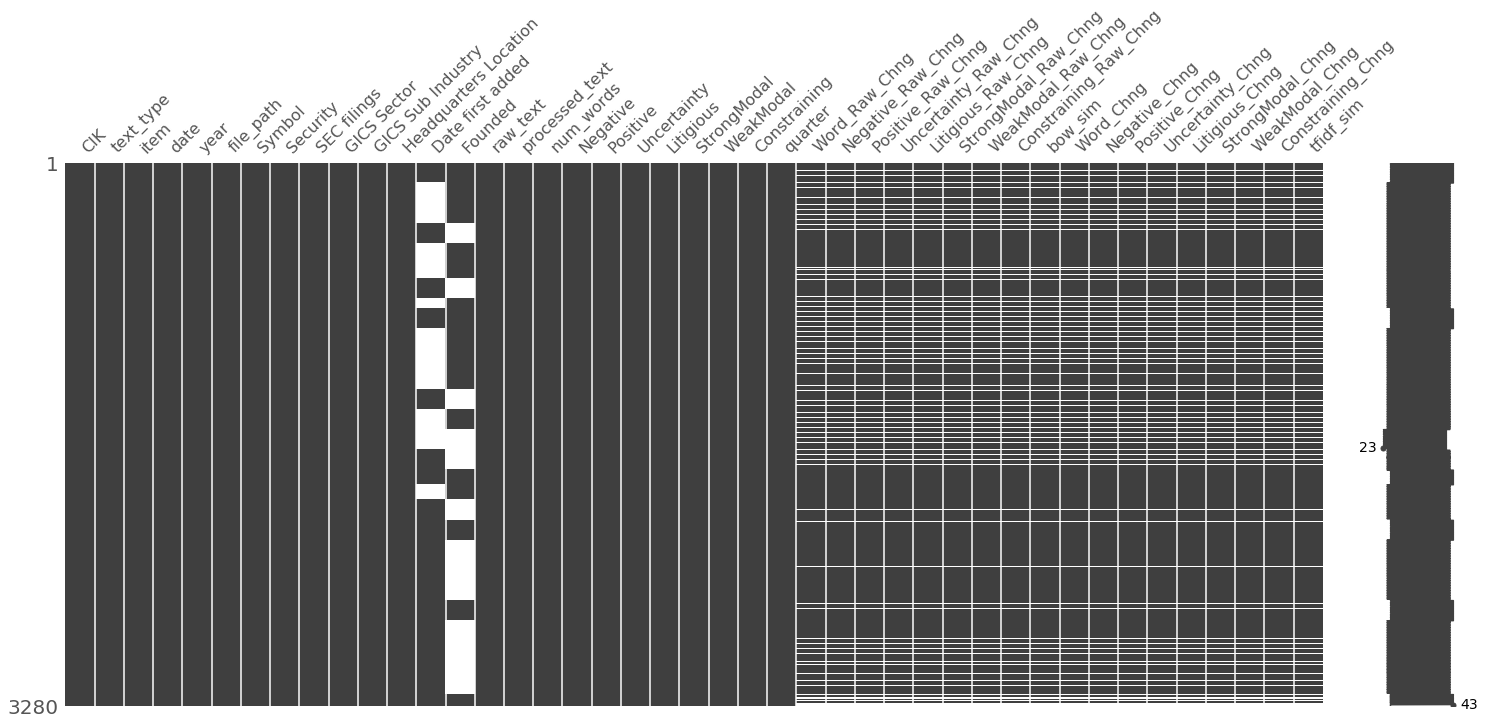

In [29]:
msno.matrix(df)

In [31]:
import seaborn as sns

In [32]:
df.columns

Index(['CIK', 'text_type', 'item', 'date', 'year', 'file_path', 'Symbol',
       'Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry',
       'Headquarters Location', 'Date first added', 'Founded', 'raw_text',
       'processed_text', 'num_words', 'Negative', 'Positive', 'Uncertainty',
       'Litigious', 'StrongModal', 'WeakModal', 'Constraining', 'quarter',
       'Word_Raw_Chng', 'Negative_Raw_Chng', 'Positive_Raw_Chng',
       'Uncertainty_Raw_Chng', 'Litigious_Raw_Chng', 'StrongModal_Raw_Chng',
       'WeakModal_Raw_Chng', 'Constraining_Raw_Chng', 'bow_sim', 'Word_Chng',
       'Negative_Chng', 'Positive_Chng', 'Uncertainty_Chng', 'Litigious_Chng',
       'StrongModal_Chng', 'WeakModal_Chng', 'Constraining_Chng', 'tfidf_sim'],
      dtype='object')

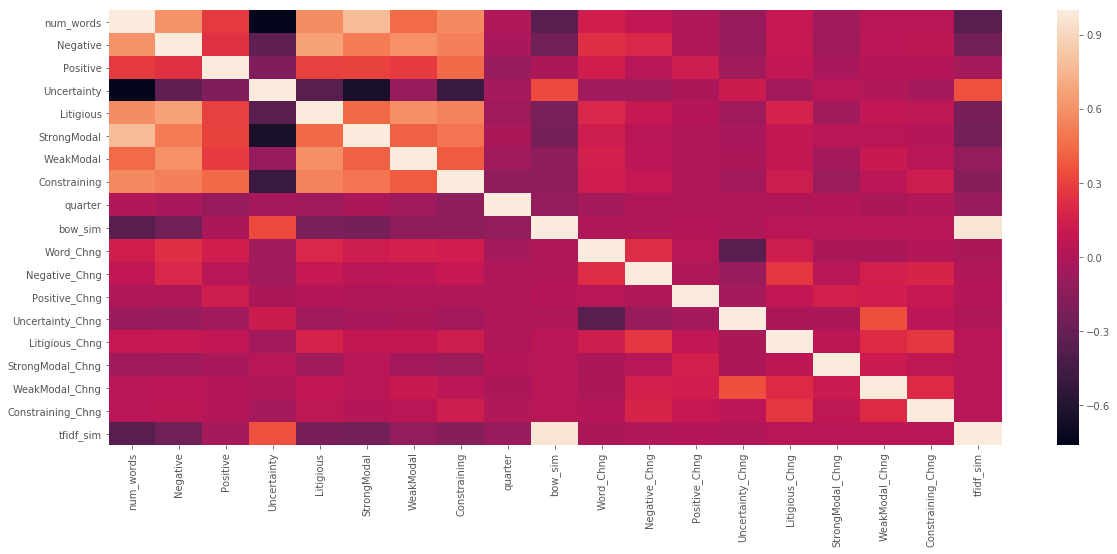

In [33]:
plt.figure(figsize=(20,8))
sns.heatmap(df[['num_words', 'Negative', 'Positive', 'Uncertainty',
       'Litigious', 'StrongModal', 'WeakModal', 'Constraining', 'quarter',
       'bow_sim', 'Word_Chng', 'Negative_Chng', 'Positive_Chng',
       'Uncertainty_Chng', 'Litigious_Chng', 'StrongModal_Chng',
       'WeakModal_Chng', 'Constraining_Chng', 'tfidf_sim']].corr(method="spearman"))

In [34]:
from pandas_datareader.data import DataReader

def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        s['Date'] = pd.to_datetime(s.index) #useful for transformation later
        s['Prev Adj Close'] = s['Adj Close'].shift(1)
        s['Log Return'] = np.log(s['Adj Close']/s['Prev Adj Close'])
        s['Return'] = (s['Adj Close']/s['Prev Adj Close']-1)
        s = s.reset_index(drop=True)
        
        cols = list(s.columns.values) # re-arrange columns
        cols.remove("Date")
        s = s[["Date"] + cols]
        s["Date"] = pd.to_datetime(s["Date"])
        s = s.set_index("Date")
        
        stocks[ticker] = s
        
    return stocks

In [35]:
stock_data = get_data_for_multiple_stocks(df.Symbol.unique(), "2010-01-01", "2020-03-01")
writer = pd.ExcelWriter("../../Processed Data/10K10Q/stock_prices.xlsx", engine='xlsxwriter')
for stock in stock_data:
    stock_data[stock].to_excel(writer, sheet_name=stock)
writer.save()

In [36]:
xls = pd.ExcelFile('../../Processed Data/10K10Q/stock_prices.xlsx')

In [37]:
stock_data = pd.read_excel(xls, sheet_name=None)

In [38]:
for ticker in stock_data:
    data = stock_data[ticker]
    data.Date = pd.to_datetime(data.Date, dayfirst=False)
    data.set_index("Date", inplace=True)

In [39]:
stock_data.keys()

odict_keys(['AXP', 'BA', 'CAT', 'JPM', 'KO', 'XOM', 'INTC', 'IBM', 'MCD', 'MMM', 'PFE', 'PG', 'TRV', 'CVX', 'UTX', 'WMT', 'JNJ', 'MRK', 'NKE', 'AAPL', 'HD', 'UNH', 'VZ', 'MSFT', 'CSCO', 'GS', 'DIS', 'V', 'WBA', 'DOW'])

In [40]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

stock_returns = dict()

# Initialise the returns to be an empty list
for i in range(1, 13):
    stock_returns["{}_month_rtn".format(i)] = []

# Iterate through the dataframe, get stock
for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    # Get the series of the stock returns
    stock = stock_data[row["Symbol"]]
    
    # Get the start date
    start_date = pd.to_datetime(row["date"], dayfirst = False) + timedelta(days=1)
    day_in_index = True
    
    # Look into stock data
    while start_date not in stock.index:
            start_date = start_date + timedelta(days = 1)
            if start_date > max(stock.index):
                day_in_index = False
                for month in range(1,13):
                    stock_returns["{}_month_rtn".format(i)].append(np.nan)
    
    if not day_in_index:
        break
            
    start_price = stock.loc[start_date]["Open"]
    
    for month in range(1, 13):
        end_date = start_date + relativedelta(months = month)
        
        if end_date > max(stock.index):
            stock_returns["{}_month_rtn".format(month)].append(np.nan)
            continue
        
        while end_date not in stock.index:
            end_date = end_date + timedelta(days = 1)
            
        end_price = stock.loc[end_date]["Open"]
        stock_returns["{}_month_rtn".format(month)].append(end_price / start_price - 1)

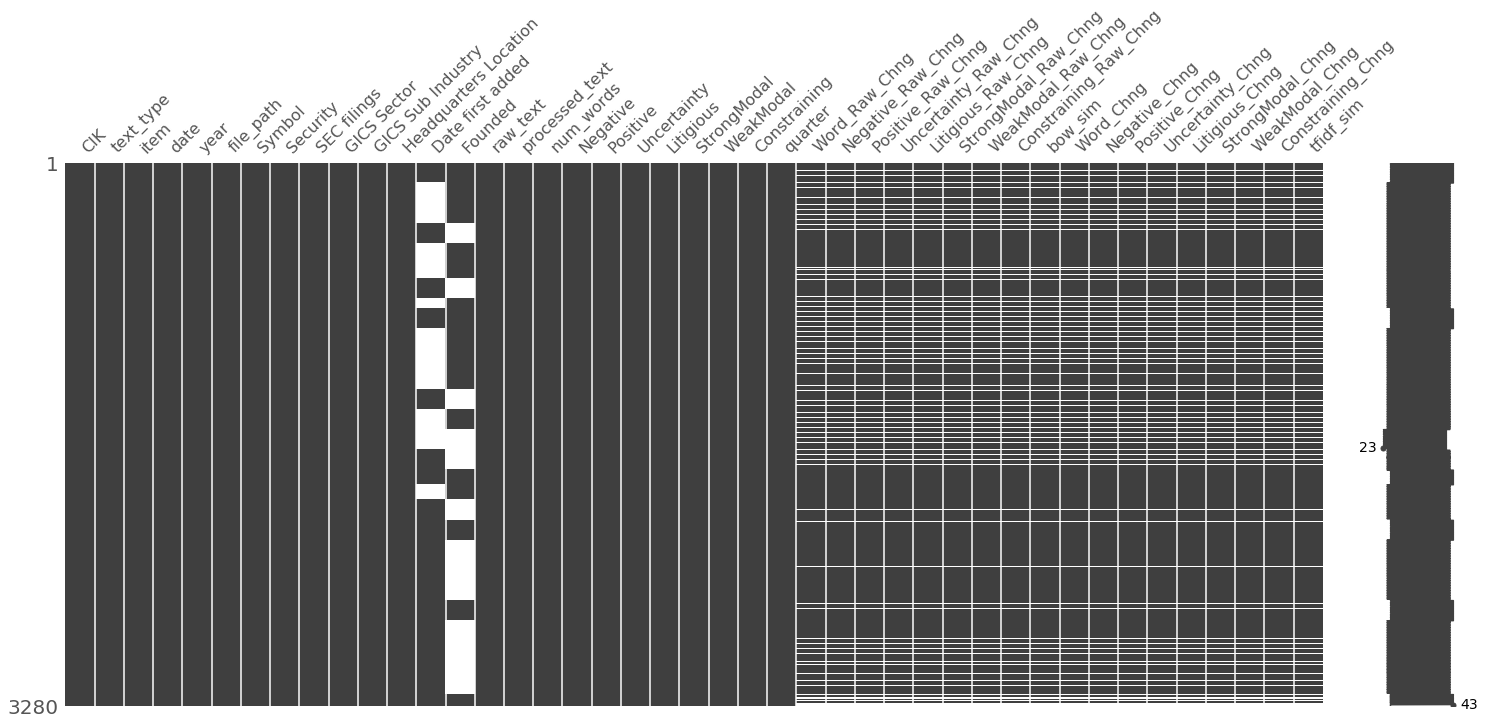

In [41]:
msno.matrix(df)

In [42]:
for rtn in stock_returns:
    df[rtn] = stock_returns[rtn]

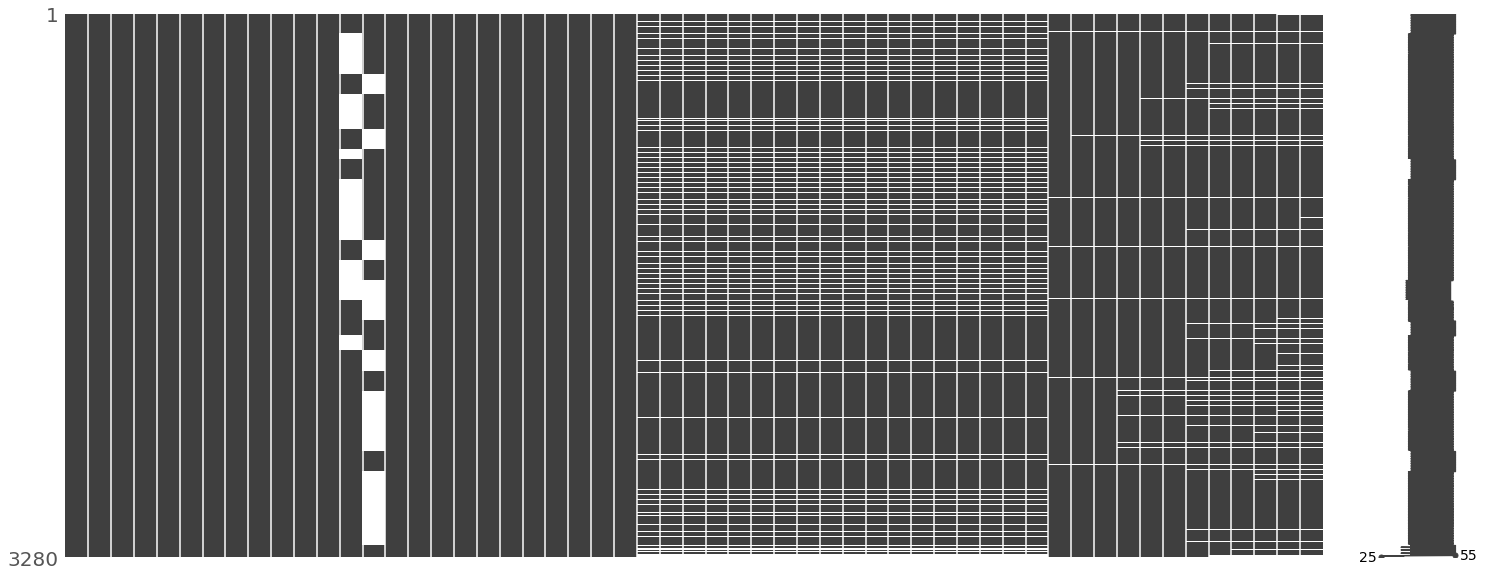

In [43]:
msno.matrix(df)

In [44]:
df.to_csv("../../Processed Data/10K10Q/10K_10Q_dataset.csv", index=False)